In [3]:
import os
from pathlib import Path
from pydub import AudioSegment
import logging

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

def convert_to_16khz(input_folder: Path, output_folder: Path) -> None:
    """Convert all audio files in a folder to 16kHz sampling rate.
    
    Parameters
    ----------
    input_folder : Path
        Path to folder containing audio files
    output_folder : Path
        Path where converted files will be saved
    """
    # Create output folder if it doesn't exist
    output_folder.mkdir(parents=True, exist_ok=True)
    
    # Supported audio formats
    audio_extensions = ('.wav', '.mp3', '.m4a', '.flac')
    
    # Get all audio files
    audio_files = [f for f in input_folder.iterdir() if f.suffix.lower() in audio_extensions]
    
    if not audio_files:
        logging.warning(f"No audio files found in {input_folder}")
        return
        
    for audio_file in audio_files:
        try:
            # Load audio file
            audio = AudioSegment.from_file(audio_file)
            
            # Convert to 16kHz
            audio_16k = audio.set_frame_rate(16000)
            
            # Create output path
            output_path = output_folder / f"{audio_file.stem}_16k{audio_file.suffix}"
            
            # Export converted audio
            audio_16k.export(output_path, format=output_path.suffix.replace('.', ''))
            
            logging.info(f"Converted: {audio_file.name}")
            
        except Exception as e:
            logging.error(f"Error converting {audio_file.name}: {e}")

if __name__ == "__main__":
    # Example usage
    input_folder = Path("/home/nele_pauline_suffo/ProcessedData/quantex_audio")
    output_folder = Path("/home/nele_pauline_suffo/ProcessedData/quantex_audio_16khz")
    
    convert_to_16khz(input_folder, output_folder)

2025-04-08 17:35:37,652 - INFO - Converted: quantex_at_home_id254922_2022_04_12_01.wav
2025-04-08 17:35:38,066 - INFO - Converted: quantex_at_home_id254922_2022_04_19_01.wav
2025-04-08 17:35:38,336 - INFO - Converted: quantex_at_home_id254922_2022_04_21_01.wav
2025-04-08 17:35:38,679 - INFO - Converted: quantex_at_home_id254922_2022_05_21_01.wav
2025-04-08 17:35:38,838 - INFO - Converted: quantex_at_home_id254922_2022_05_21_02.wav
2025-04-08 17:35:39,211 - INFO - Converted: quantex_at_home_id254922_2022_06_29_01.wav
2025-04-08 17:35:39,586 - INFO - Converted: quantex_at_home_id254922_2022_06_29_02.wav
2025-04-08 17:35:39,988 - INFO - Converted: quantex_at_home_id254922_2022_06_29_03.wav
2025-04-08 17:35:40,323 - INFO - Converted: quantex_at_home_id255237_2022_05_08_01.wav
2025-04-08 17:35:40,696 - INFO - Converted: quantex_at_home_id255237_2022_05_08_02.wav
2025-04-08 17:35:41,033 - INFO - Converted: quantex_at_home_id255237_2022_05_08_03.wav
2025-04-08 17:35:41,172 - INFO - Converted:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from src.constants import VTCPaths

def plot_annotations_vs_predictions(audio_file_name: str, duration_off: float = 0.0):
    """
    This function plots the annotations and predictions for a given audio file.
    The annotations are plotted in green and the predictions are plotted in blue.
    
    Parameters
    ----------
    audio_file_name : str
        The name of the audio file to plot the annotations and predictions for.
    duration_off : float
        The duration an utterance has to be off to be considered actually off by the model.
    """
    gt_df = pd.read_pickle(VTCPaths.childlens_gt_df_file_path)
    if duration_off == 0.1:
        predictions_df = pd.read_pickle(VTCPaths.childlens_df_file_path_01)
    elif duration_off == 2.0:
        predictions_df = pd.read_pickle(VTCPaths.childlens_df_file_path_20)

    # Strip the audio_file_name by removing the '_16kHz' extension and everything afterwards
    predictions_df['audio_file_name'] = predictions_df['audio_file_name'].str.split('_').str[0]

    example_annotation = gt_df[gt_df['audio_file_name'] == audio_file_name]
    example_prediction = predictions_df[predictions_df['audio_file_name'] == audio_file_name]

    # Set up the figure and axis
    plt.figure(figsize=(12, 2))
    ax = plt.gca()

    ground_truth_fem = example_annotation[example_annotation['Voice_type'] == 'FEM']
    ground_truth_mal = example_annotation[example_annotation['Voice_type'] == 'MAL']
    ground_truth_kchi = example_annotation[example_annotation['Voice_type'] == 'KCHI']
    ground_truth_chi = example_annotation[example_annotation['Voice_type'] == 'CHI']
    ground_truth_speech = example_annotation[example_annotation['Voice_type'] == 'SPEECH']
    predictions_fem = example_prediction[example_prediction['Voice_type'] == 'FEM']
    predictions_mal = example_prediction[example_prediction['Voice_type'] == 'MAL']
    predictions_kchi = example_prediction[example_prediction['Voice_type'] == 'KCHI']
    predictions_chi = example_prediction[example_prediction['Voice_type'] == 'CHI']
    predictions_speech = example_prediction[example_prediction['Voice_type'] == 'SPEECH']

    # Define y-positions for the two bars
    y_ground_truth_kchi = 9
    y_predictions_kchi = 8

    y_ground_truth_fem = 7
    y_predictions_fem = 6

    y_ground_truth_chi= 5
    y_predictions_chi = 4 

    y_ground_truth_mal = 3
    y_predictions_mal = 2

    y_ground_truth_speech = 1
    y_predictions_speech = 0

    # Plot predictions, excluding SPEECH
    for idx, row in predictions_fem.iterrows():
        ax.barh(y_predictions_fem, row['Utterance_Duration'], left=row['Utterance_Start'], color='blue', edgecolor='black', alpha=0.7)

    for idx, row in predictions_mal.iterrows():
        ax.barh(y_predictions_mal, row['Utterance_Duration'], left=row['Utterance_Start'], color='blue', edgecolor='black', alpha=0.7)

    for idx, row in predictions_kchi.iterrows():
        ax.barh(y_predictions_kchi, row['Utterance_Duration'], left=row['Utterance_Start'], color='blue', edgecolor='black', alpha=0.7)

    for idx, row in predictions_chi.iterrows():
        ax.barh(y_predictions_chi, row['Utterance_Duration'], left=row['Utterance_Start'], color='blue', edgecolor='black', alpha=0.7)

    for idx, row in predictions_speech.iterrows():
        ax.barh(y_predictions_speech, row['Utterance_Duration'], left=row['Utterance_Start'], color='blue', edgecolor='black', alpha=0.7)

    for idx, row in ground_truth_fem.iterrows():
        ax.barh(y_ground_truth_fem, row['Utterance_Duration'], left=row['Utterance_Start'], color='green', edgecolor='black', alpha=0.7)

    for idx, row in ground_truth_mal.iterrows():
        ax.barh(y_ground_truth_mal, row['Utterance_Duration'], left=row['Utterance_Start'], color='green', edgecolor='black', alpha=0.7)

    for idx, row in ground_truth_kchi.iterrows():
        ax.barh(y_ground_truth_kchi, row['Utterance_Duration'], left=row['Utterance_Start'], color='green', edgecolor='black', alpha=0.7)

    for idx, row in ground_truth_chi.iterrows():
        ax.barh(y_ground_truth_chi, row['Utterance_Duration'], left=row['Utterance_Start'], color='green', edgecolor='black', alpha=0.7)

    for idx, row in ground_truth_speech.iterrows():
        ax.barh(y_ground_truth_speech, row['Utterance_Duration'], left=row['Utterance_Start'], color='green', edgecolor='black', alpha=0.7)

    # Adjust y-axis ticks and labels
    ax.set_yticks([y_ground_truth_speech, y_predictions_speech, y_ground_truth_fem, y_predictions_fem, y_ground_truth_mal, y_predictions_mal, y_ground_truth_kchi, y_predictions_kchi, y_ground_truth_chi, y_predictions_chi])
    ax.set_yticklabels(["GT SPEECH", "Pred SPEECH", "GT FEM", "Pred FEM", "GT MAL", "Pred MAL", "GT KCHI", "Pred KCHI", "GT CHI", "Pred CHI"])

    # Add labels and titles
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Category")
    ax.set_title("Annotations vs Predictions")
    ax.set_xlim(0, 250)

In [5]:
gt_df = pd.read_pickle(VTCPaths.childlens_gt_df_file_path)


In [6]:
example_annotation = gt_df[gt_df['audio_file_name'] == '300654']
example_annotation[example_annotation['Voice_type'] == 'KCHI']


,audio_file_name,Utterance_Start,Utterance_Duration,Voice_type,Utterance_End
5783,300654,5.608,1.338,KCHI,6.946
5787,300654,9.210,1.750,KCHI,10.960
5806,300654,1242.110,1.543,KCHI,1243.653
5808,300654,26.828,272.224,KCHI,299.052
5810,300654,26.828,272.224,KCHI,299.052
5812,300654,116.914,1.825,KCHI,118.739


## Plot Results

ValueError: Can only compare identically-labeled Series objects

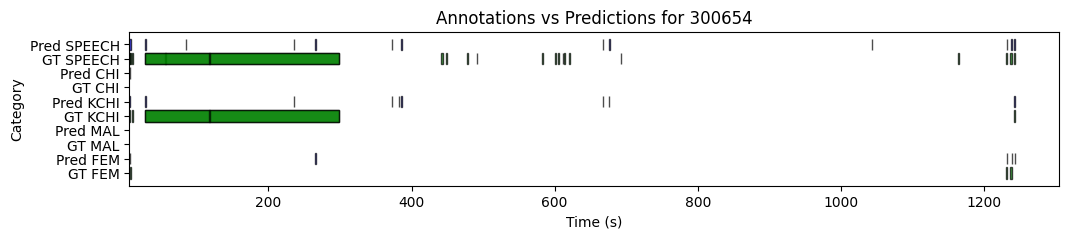

In [2]:
plot_annotations_vs_predictions('300654', 2.0)

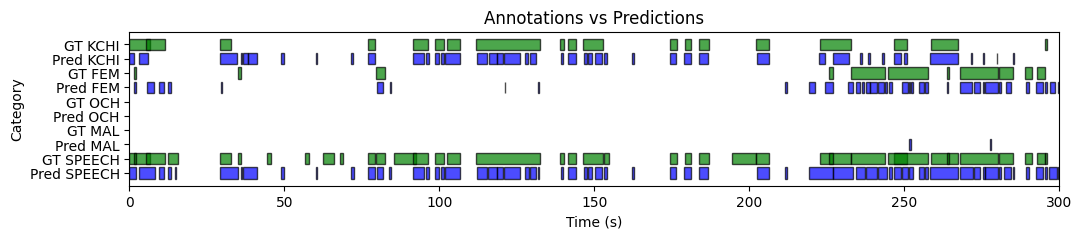

In [3]:
plot_annotations_vs_predictions('284099', 0.1)

## Compute Evaluation Metrics

In [39]:
compute_metrics('quantex_share_vtc_output_01.pkl')

/home/nele_pauline_suffo/.conda/envs/pyannote/lib/python3.8/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(



Averaged Metrics Per Class Over All Videos:
Class 'KCHI':
  Precision: 0.779
  Recall: 0.526
  F1 Score: 0.591
  Error Rate: 0.725

Class 'OCH':
  Precision: 1.000
  Recall: 0.792
  F1 Score: 0.792
  Error Rate: 0.208

Class 'FEM':
  Precision: 0.325
  Recall: 0.644
  F1 Score: 0.334
  Error Rate: 6.666

Class 'MAL':
  Precision: 0.243
  Recall: 0.675
  F1 Score: 0.178
  Error Rate: 3.131

Class 'SPEECH':
  Precision: 0.780
  Recall: 0.682
  F1 Score: 0.683
  Error Rate: 1.798

Final F1 Score over all classes: 0.515


In [40]:
compute_metrics('quantex_share_vtc_output_03.pkl')

/home/nele_pauline_suffo/.conda/envs/pyannote/lib/python3.8/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(



Averaged Metrics Per Class Over All Videos:
Class 'KCHI':
  Precision: 0.778
  Recall: 0.532
  F1 Score: 0.595
  Error Rate: 0.723

Class 'OCH':
  Precision: 1.000
  Recall: 0.792
  F1 Score: 0.792
  Error Rate: 0.208

Class 'FEM':
  Precision: 0.324
  Recall: 0.650
  F1 Score: 0.335
  Error Rate: 6.784

Class 'MAL':
  Precision: 0.244
  Recall: 0.676
  F1 Score: 0.179
  Error Rate: 3.158

Class 'SPEECH':
  Precision: 0.779
  Recall: 0.692
  F1 Score: 0.688
  Error Rate: 1.810

Final F1 Score over all classes: 0.518


In [41]:
compute_metrics('quantex_share_vtc_output_20.pkl')

/home/nele_pauline_suffo/.conda/envs/pyannote/lib/python3.8/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(



Averaged Metrics Per Class Over All Videos:
Class 'KCHI':
  Precision: 0.751
  Recall: 0.653
  F1 Score: 0.657
  Error Rate: 0.707

Class 'OCH':
  Precision: 1.000
  Recall: 0.792
  F1 Score: 0.792
  Error Rate: 0.208

Class 'FEM':
  Precision: 0.305
  Recall: 0.768
  F1 Score: 0.353
  Error Rate: 8.782

Class 'MAL':
  Precision: 0.240
  Recall: 0.703
  F1 Score: 0.189
  Error Rate: 3.533

Class 'SPEECH':
  Precision: 0.751
  Recall: 0.822
  F1 Score: 0.742
  Error Rate: 2.013

Final F1 Score over all classes: 0.547


### Length of each Voice Type Class

In [17]:
gt_df = pd.read_pickle(VTCPaths.childlens_gt_df_file_path)
# sum utterance durations for each Voice_type in minutes (divide by 60)
gt_df.groupby('Voice_type')['Utterance_Duration'].sum() / 60

Voice_type
FEM        280.525750
KCHI       731.155017
MAL        114.184067
OCH         40.292133
SPEECH    1465.549850
Name: Utterance_Duration, dtype: float64